<a href="https://colab.research.google.com/github/ugurdonmez/bitcoin_price_predict/blob/main/BitcoinPricePrediction_DimensionReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

from mpl_toolkits.mplot3d import Axes3D

import re
from collections import OrderedDict
from time import time
import sqlite3       

from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

In [2]:
from google.colab import drive

In [3]:
%cd /content/drive/MyDrive/Colab\ Notebooks/bitcoin

/content/drive/MyDrive/Colab Notebooks/bitcoin


In [4]:
%ls

BitcoinPricePrediction.ipynb  BTC-USD.csv           save.csv
Bitstamp_BTCUSD_minute.csv    case_3_bitcoin.ipynb
BitstampData_sample.csv       fixed.csv


In [5]:
dataset = pd.read_csv('save.csv')

In [7]:
dataset.head()

,close,Volume BTC,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
0,18511.57,1.471611,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18517.30,1.535443,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,18520.98,4.143530,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18494.31,3.089814,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,18512.82,1.200447,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [9]:
dataset.dropna()

,close,Volume BTC,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
201,18078.85,5.352453,0.0,18107.265770,18129.217677,18250.984978,0.056950,-0.445820,-22.26,-105.30,40.680283,42.515090,44.066318,17.711172,50.297651,14.026433,32.235012,4.883479,11.223026,18100.352,18122.715667,18300.97720
202,18050.00,26.294062,0.0,18096.853812,18124.106853,18248.682771,-0.144666,-0.276463,-18.56,-109.81,35.473036,40.567919,43.717012,0.000000,17.698196,0.000000,13.037741,0.000000,4.539254,18098.496,18119.055333,18298.62230
203,18029.31,35.771513,0.0,18084.573119,18117.990919,18246.173713,-0.343092,-0.436594,-46.84,-70.73,32.189713,39.234795,43.468660,10.534392,9.415188,7.646859,7.224431,3.152703,2.678728,18093.812,18116.697667,18296.29730
204,18010.00,3.582871,0.0,18071.014370,18111.023755,18243.476507,-0.482997,-0.604925,-81.38,-98.37,29.370631,38.028262,43.238260,0.000000,3.511464,0.000000,2.548953,0.000000,1.050901,18085.674,18113.418667,18293.78320
205,17978.68,110.041593,0.0,18054.226303,18102.485439,18240.456856,-0.685750,-0.864986,-118.73,-140.93,25.366979,36.162366,42.867873,8.941687,6.492026,6.991174,4.879345,3.355593,2.169432,18073.801,18108.721000,18291.20050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211165,49218.70,1.289475,0.0,49352.335057,49387.106945,49595.973984,-0.754383,-0.392007,-336.06,-149.30,36.005034,43.663897,47.137164,0.811528,6.643047,31.604658,37.434967,21.186836,25.095304,49428.432,49348.626333,49591.33760
211166,49203.64,0.909304,0.0,49325.299592,49375.270368,49592.070163,-0.869024,-0.528333,-389.18,-208.76,35.055464,43.253778,47.062690,2.350901,5.739720,29.326981,34.749445,19.659948,23.295009,49389.514,49341.667667,49588.17850
211167,49167.01,0.646974,0.0,49296.519666,49361.834215,49587.840709,-1.014517,-0.482015,-467.97,-297.97,32.723143,42.255152,46.881627,2.580857,1.914429,23.787054,28.239564,15.946143,18.930976,49342.717,49331.735333,49584.66235
211168,49123.32,0.725619,0.0,49265.028818,49346.446201,49583.218613,-0.887773,-0.465624,-547.61,-281.83,30.071638,41.084768,46.666409,6.198765,3.710174,17.179371,23.431135,11.516546,15.707546,49287.956,49322.341000,49580.92705


In [10]:
dataset = dataset.dropna(axis=0)

In [11]:
dataset

,close,Volume BTC,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
201,18078.85,5.352453,0.0,18107.265770,18129.217677,18250.984978,0.056950,-0.445820,-22.26,-105.30,40.680283,42.515090,44.066318,17.711172,50.297651,14.026433,32.235012,4.883479,11.223026,18100.352,18122.715667,18300.97720
202,18050.00,26.294062,0.0,18096.853812,18124.106853,18248.682771,-0.144666,-0.276463,-18.56,-109.81,35.473036,40.567919,43.717012,0.000000,17.698196,0.000000,13.037741,0.000000,4.539254,18098.496,18119.055333,18298.62230
203,18029.31,35.771513,0.0,18084.573119,18117.990919,18246.173713,-0.343092,-0.436594,-46.84,-70.73,32.189713,39.234795,43.468660,10.534392,9.415188,7.646859,7.224431,3.152703,2.678728,18093.812,18116.697667,18296.29730
204,18010.00,3.582871,0.0,18071.014370,18111.023755,18243.476507,-0.482997,-0.604925,-81.38,-98.37,29.370631,38.028262,43.238260,0.000000,3.511464,0.000000,2.548953,0.000000,1.050901,18085.674,18113.418667,18293.78320
205,17978.68,110.041593,0.0,18054.226303,18102.485439,18240.456856,-0.685750,-0.864986,-118.73,-140.93,25.366979,36.162366,42.867873,8.941687,6.492026,6.991174,4.879345,3.355593,2.169432,18073.801,18108.721000,18291.20050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211165,49218.70,1.289475,0.0,49352.335057,49387.106945,49595.973984,-0.754383,-0.392007,-336.06,-149.30,36.005034,43.663897,47.137164,0.811528,6.643047,31.604658,37.434967,21.186836,25.095304,49428.432,49348.626333,49591.33760
211166,49203.64,0.909304,0.0,49325.299592,49375.270368,49592.070163,-0.869024,-0.528333,-389.18,-208.76,35.055464,43.253778,47.062690,2.350901,5.739720,29.326981,34.749445,19.659948,23.295009,49389.514,49341.667667,49588.17850
211167,49167.01,0.646974,0.0,49296.519666,49361.834215,49587.840709,-1.014517,-0.482015,-467.97,-297.97,32.723143,42.255152,46.881627,2.580857,1.914429,23.787054,28.239564,15.946143,18.930976,49342.717,49331.735333,49584.66235
211168,49123.32,0.725619,0.0,49265.028818,49346.446201,49583.218613,-0.887773,-0.465624,-547.61,-281.83,30.071638,41.084768,46.666409,6.198765,3.710174,17.179371,23.431135,11.516546,15.707546,49287.956,49322.341000,49580.92705


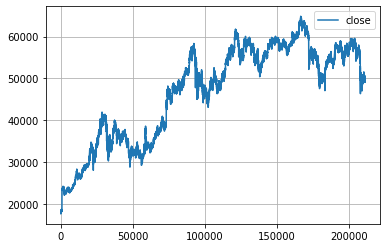

In [12]:
dataset[['close']].plot(grid=True)
plt.show()

In [13]:
subset_dataset= dataset.iloc[-1000:]
Y= subset_dataset["signal"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
rescaledDataset = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,close,Volume BTC,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
210552,-0.089352,-0.144169,0.045778,0.067651,0.441378,-0.606349,-0.117003,-0.644785,-0.108957,-1.117596,-0.784111,-0.898720,-1.339069,-1.164711,-1.448584,-1.216488,-1.434667,-1.381556,0.068142,0.065538,0.465312
211164,-1.511096,-0.400760,-1.404130,-1.451727,-1.601474,-1.319441,-0.069433,-1.057912,-0.046336,-0.508307,-0.306157,-0.667033,-1.057803,-1.429161,-0.043462,-0.099952,-0.484290,-0.527681,-1.261181,-1.516119,-1.588214


Variance preserved by first 5 components == 94.67%


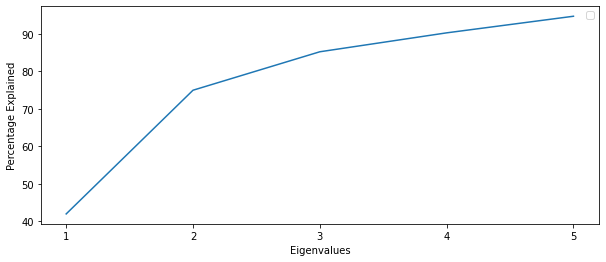

In [15]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rescaledDataset)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(rescaledDataset)
ax = plt_data.plot(kind='line', figsize=(10, 4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Eigenvalues")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Variance preserved by first 5 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [16]:
dfsvd = pd.DataFrame(Y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rescaledDataset.index)
print(dfsvd.shape)
dfsvd.head()

(800, 5)


,c0,c1,c2,c3,c4
210552,-2.937342,1.568107,-0.216217,-1.381021,0.063963
211164,-3.274973,-2.458524,2.149628,-0.829787,0.448609
211152,-0.776474,-4.221140,-1.069048,2.217528,1.651880
210217,4.375521,0.375089,-0.965670,0.369868,-0.198657
210691,0.438095,-1.010360,2.729373,-0.859546,0.415855


In [17]:
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

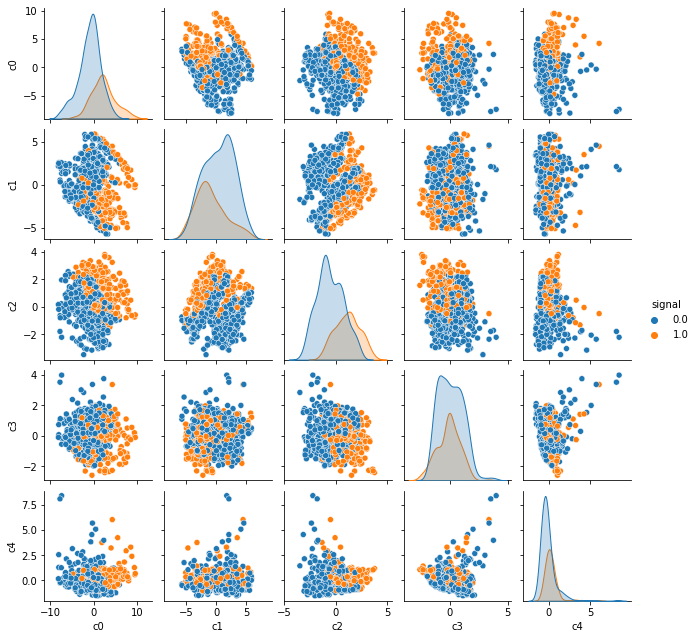

In [18]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['signal']=Y_train
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='signal', size=1.8)

In [20]:
X

,close,Volume BTC,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
210170,50920.25,2.501352,50923.645760,50837.435792,50566.949562,-0.104603,0.208978,-105.66,258.65,53.565793,58.505329,53.094588,41.861103,24.505591,69.382002,69.272487,85.095234,81.691588,50943.820,50870.817333,50609.98410
210171,50848.16,2.193445,50909.921077,50838.127677,50569.747676,-0.249708,-0.032125,-125.41,34.10,43.884976,55.200667,52.638176,9.419129,24.207511,52.013010,63.277915,77.074897,80.758533,50931.279,50871.954000,50611.34350
210172,50782.19,5.246979,50886.697245,50834.518794,50571.861530,-0.367025,-0.165277,-193.26,-82.31,37.072495,52.398799,52.225284,8.087754,19.789329,36.118540,52.504518,69.735437,77.301856,50911.953,50869.210333,50612.16985
210173,50810.20,0.123660,50872.788655,50832.949840,50574.233057,-0.366902,0.084345,-159.06,-56.06,41.366471,53.436890,52.384661,18.278396,11.928426,42.867124,43.666225,72.851675,73.220670,50896.047,50867.341667,50613.30055
210174,50846.32,1.689424,50867.976172,50833.812431,50576.940390,-0.366076,0.252236,-150.99,78.94,46.588573,54.753214,52.589642,31.419632,19.261927,51.569690,43.518452,76.870188,73.152434,50880.948,50869.973000,50614.55785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211165,49218.70,1.289475,49352.335057,49387.106945,49595.973984,-0.754383,-0.392007,-336.06,-149.30,36.005034,43.663897,47.137164,0.811528,6.643047,31.604658,37.434967,21.186836,25.095304,49428.432,49348.626333,49591.33760
211166,49203.64,0.909304,49325.299592,49375.270368,49592.070163,-0.869024,-0.528333,-389.18,-208.76,35.055464,43.253778,47.062690,2.350901,5.739720,29.326981,34.749445,19.659948,23.295009,49389.514,49341.667667,49588.17850
211167,49167.01,0.646974,49296.519666,49361.834215,49587.840709,-1.014517,-0.482015,-467.97,-297.97,32.723143,42.255152,46.881627,2.580857,1.914429,23.787054,28.239564,15.946143,18.930976,49342.717,49331.735333,49584.66235
211168,49123.32,0.725619,49265.028818,49346.446201,49583.218613,-0.887773,-0.465624,-547.61,-281.83,30.071638,41.084768,46.666409,6.198765,3.710174,17.179371,23.431135,11.516546,15.707546,49287.956,49322.341000,49580.92705


In [21]:
dataset

,close,Volume BTC,signal,EMA10,EMA30,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,RSI30,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
201,18078.85,5.352453,0.0,18107.265770,18129.217677,18250.984978,0.056950,-0.445820,-22.26,-105.30,40.680283,42.515090,44.066318,17.711172,50.297651,14.026433,32.235012,4.883479,11.223026,18100.352,18122.715667,18300.97720
202,18050.00,26.294062,0.0,18096.853812,18124.106853,18248.682771,-0.144666,-0.276463,-18.56,-109.81,35.473036,40.567919,43.717012,0.000000,17.698196,0.000000,13.037741,0.000000,4.539254,18098.496,18119.055333,18298.62230
203,18029.31,35.771513,0.0,18084.573119,18117.990919,18246.173713,-0.343092,-0.436594,-46.84,-70.73,32.189713,39.234795,43.468660,10.534392,9.415188,7.646859,7.224431,3.152703,2.678728,18093.812,18116.697667,18296.29730
204,18010.00,3.582871,0.0,18071.014370,18111.023755,18243.476507,-0.482997,-0.604925,-81.38,-98.37,29.370631,38.028262,43.238260,0.000000,3.511464,0.000000,2.548953,0.000000,1.050901,18085.674,18113.418667,18293.78320
205,17978.68,110.041593,0.0,18054.226303,18102.485439,18240.456856,-0.685750,-0.864986,-118.73,-140.93,25.366979,36.162366,42.867873,8.941687,6.492026,6.991174,4.879345,3.355593,2.169432,18073.801,18108.721000,18291.20050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211165,49218.70,1.289475,0.0,49352.335057,49387.106945,49595.973984,-0.754383,-0.392007,-336.06,-149.30,36.005034,43.663897,47.137164,0.811528,6.643047,31.604658,37.434967,21.186836,25.095304,49428.432,49348.626333,49591.33760
211166,49203.64,0.909304,0.0,49325.299592,49375.270368,49592.070163,-0.869024,-0.528333,-389.18,-208.76,35.055464,43.253778,47.062690,2.350901,5.739720,29.326981,34.749445,19.659948,23.295009,49389.514,49341.667667,49588.17850
211167,49167.01,0.646974,0.0,49296.519666,49361.834215,49587.840709,-1.014517,-0.482015,-467.97,-297.97,32.723143,42.255152,46.881627,2.580857,1.914429,23.787054,28.239564,15.946143,18.930976,49342.717,49331.735333,49584.66235
211168,49123.32,0.725619,0.0,49265.028818,49346.446201,49583.218613,-0.887773,-0.465624,-547.61,-281.83,30.071638,41.084768,46.666409,6.198765,3.710174,17.179371,23.431135,11.516546,15.707546,49287.956,49322.341000,49580.92705


In [22]:
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [23]:
dfsvd['signal'] = Y_train
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

In [24]:
tsne = TSNE(n_components=2, random_state=0)

In [25]:
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

In [26]:
dftsne['signal'] = Y_train

Text(0.5, 1.0, 'Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

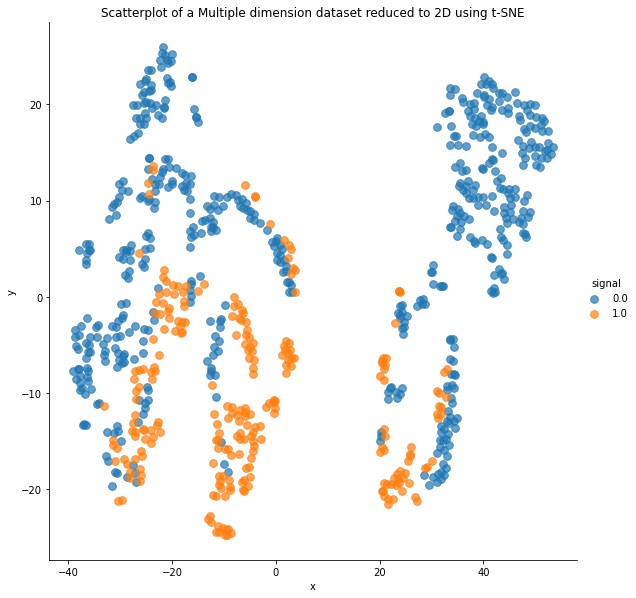

In [27]:
g = sns.lmplot('x', 'y', dftsne, hue='signal', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a Multiple dimension dataset reduced to 2D using t-SNE')

In [28]:
scoring = 'accuracy'

In [29]:
import time
start_time = time.time()

In [31]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [35]:
num_folds = 10
seed = 7

In [36]:
kfold = KFold(n_splits=num_folds, random_state=seed)

In [37]:
models =  RandomForestClassifier(n_jobs=-1)
cv_results_XTrain= cross_val_score(models, X_train, Y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 418.2363624572754 seconds ---


In [38]:
start_time = time.time()
X_SVD= dfsvd[svdcols].iloc[:,:5]
cv_results_SVD = cross_val_score(models, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 3.57604718208313 seconds ---


In [39]:
print("Result without dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without dimensionality Reduction: 0.970000 (0.019526)
Result with dimensionality Reduction: 0.938750 (0.025890)
